In [369]:
# from google.colab import drive
# drive.mount('/content/drive')

######### implemented Locally

In [370]:
import pandas as pd

ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

In [371]:
movies.head(5)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [372]:
ratings.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354


### Content Based

**Objective**: Build a Content-Based Recommendation system that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre.

**Dataset**:
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Split the `genres` column into separate genre strings.
   - Fill any missing values in the `genres` column and convert it to string.

2. **Compute TF-IDF Matrix**:
   - Use `TfidfVectorizer` to transform the genres into a TF-IDF matrix.

3. **Calculate Cosine Similarity**:
   - Compute cosine similarity between the TF-IDF matrices of movies.

4. **Recommend Movies**:
   - Create a function that gets movie recommendations based on the cosine similarity score of movie genres.

In [373]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna("").astype('str')

In [374]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])

In [375]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.14193614 0.09010857 ... 0.         0.         0.        ]
 [0.14193614 1.         0.         ... 0.         0.         0.        ]
 [0.09010857 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         1.         0.3165589 ]
 [0.         0.         0.         ... 1.         1.         0.3165589 ]
 [0.         0.         0.         ... 0.3165589  0.3165589  1.        ]]


In [376]:
import numpy as np

def genre_recommendations(title, n=10):
    pos = None
    for idx, movie in enumerate(movies['title']):
        if movie == title:
            pos = idx
            break
    if pos is None:
        print("No movie with that title")
        return None
    order = np.argsort(cosine_sim[pos])[::-1]
    return movies['title'][order][:n]

In [377]:
# Example
genre_recommendations('GoldenEye (1995)')

788                     Daylight (1996)
1467                    Anaconda (1997)
1513                     Con Air (1997)
978                 Maximum Risk (1996)
1693                   Firestorm (1998)
724                    Rock, The (1996)
825               Chain Reaction (1996)
345     Clear and Present Danger (1994)
9                      GoldenEye (1995)
543           Surviving the Game (1994)
Name: title, dtype: object


### Collaborative Filtering

**Objective**: Implement a collaborative filtering movie recommendation system to recommend movies to a user based on similar users' spreferences.

**Dataset**:

- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Split `genres` column into separate rows.

2. **Create User-Genre Matrix**:
   - Create a matrix where rows are users and columns are genres.
   - Each cell represents the ratio of movies watched by the user in that genre to the total movies watched by the user.

3. **Calculate User Similarity**:
   - Use cosine similarity to calculate the similarity between users.

4. **Find Top N Similar Users**:
   - Find the top N users with the most similar preferences to the given user.

5. **Recommend Movies**:
   - Recommend movies that similar users have watched but the target user has not.
   - Return titles and genres of the top 10 recommended movies.

In [378]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [379]:
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

data = pd.merge(ratings, movies, on='movie_id')

In [380]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),Drama


In [381]:
data = data.assign(genres=data['genres'].str.split('|')).explode('genres')

In [382]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),Drama


In [383]:
from tqdm import tqdm

unique_genres = list(data['genres'].unique())
user_count = max(data['user_id'])
genre_cnt = np.zeros((user_count, len(unique_genres)))

for row in tqdm(data.itertuples()): # iter tuples is faster
    genre_id = unique_genres.index(row[7])
    genre_cnt[row[4]][genre_id] += 1

for i in tqdm(range(len(genre_cnt))):
    genre_cnt[i] /= np.linalg.norm(genre_cnt[i]) # normalized by size vector. because I found it more reasonable later on

cosine_sim = linear_kernel(genre_cnt, genre_cnt)
print(cosine_sim)


2101815it [00:03, 581009.71it/s]
100%|██████████| 6040/6040 [00:00<00:00, 216795.14it/s]


[[1.         0.59392652 0.52642667 ... 0.69834932 0.78068502 0.68939203]
 [0.59392652 1.         0.66903366 ... 0.70715636 0.56343175 0.90698096]
 [0.52642667 0.66903366 1.         ... 0.68705058 0.6779119  0.62134421]
 ...
 [0.69834932 0.70715636 0.68705058 ... 1.         0.81983412 0.86195747]
 [0.78068502 0.56343175 0.6779119  ... 0.81983412 1.         0.71068362]
 [0.68939203 0.90698096 0.62134421 ... 0.86195747 0.71068362 1.        ]]


In [384]:
def get_top_n_similar_users(user_id, n=5):
    order = np.argsort(cosine_sim[user_id])[::-1]
    return order[:n]

In [385]:
def recommend_movies(user_id, n_similar_users=5, n_recommendations=10):
    similars = get_top_n_similar_users(user_id, n_similar_users)
    print("similars:", similars)
    seen_movies = ratings[ratings.user_id == user_id]['movie_id']
    movie_scores = {}
    for similar in similars:
        similar_movies = ratings[ratings.user_id == similar]['movie_id']
        for movie in similar_movies:
            if movie in seen_movies:
                continue
            if movie_scores.get(movie) is None:
                movie_scores[movie] = 0
            movie_scores[movie] += 1

    sorted_movies = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)
    print("sorted_movies:", sorted_movies)
    sorted_ids = [x[0] for x in sorted_movies]
    mask = movies['movie_id'].isin(sorted_ids[:n_recommendations])
    return movies[mask]

In [386]:
# Example
user_id = 1
recommended_movies = recommend_movies(user_id, n_similar_users=5, n_recommendations=10)

similars: [   1 3107 2038 3034 3822]
sorted_movies: [(2858, 4), (1193, 3), (3408, 3), (1035, 3), (2791, 3), (2321, 3), (1270, 3), (527, 3), (260, 3), (1207, 3), (608, 3), (2997, 3), (2640, 3), (356, 3), (1214, 3), (541, 3), (1617, 3), (1307, 3), (1704, 3), (2396, 3), (914, 2), (1197, 2), (1287, 2), (594, 2), (919, 2), (595, 2), (938, 2), (2918, 2), (2797, 2), (2340, 2), (1097, 2), (1721, 2), (3186, 2), (1022, 2), (150, 2), (2692, 2), (1028, 2), (1029, 2), (2028, 2), (3114, 2), (1291, 2), (924, 2), (3285, 2), (1127, 2), (3671, 2), (2124, 2), (3868, 2), (3155, 2), (141, 2), (2706, 2), (3524, 2), (1784, 2), (1210, 2), (3755, 2), (1252, 2), (1258, 2), (1265, 2), (593, 2), (3037, 2), (1294, 2), (1299, 2), (920, 2), (926, 2), (3201, 2), (3068, 2), (3072, 2), (2289, 2), (3099, 2), (1641, 2), (3424, 2), (235, 2), (253, 2), (296, 2), (2871, 2), (1198, 2), (1358, 2), (2324, 2), (1387, 2), (858, 2), (3152, 2), (3167, 2), (3168, 2), (2369, 2), (111, 2), (2533, 2), (1732, 2), (3504, 2), (3362, 2), 

In [387]:
recommended_movies

,movie_id,title,genres
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
523,527,Schindler's List (1993),Drama|War
1022,1035,"Sound of Music, The (1965)",Musical
1176,1193,One Flew Over the Cuckoo's Nest (1975),Drama
1189,1207,To Kill a Mockingbird (1962),Drama
1250,1270,Back to the Future (1985),Comedy|Sci-Fi
2252,2321,Pleasantville (1998),Comedy
2722,2791,Airplane! (1980),Comedy
2789,2858,American Beauty (1999),Comedy|Drama
3339,3408,Erin Brockovich (2000),Drama


### SVD (Singular Value Decomposition)



**Objective**: Implement an SVD-based recommendation system to recommend movies to users by decomposing the user-item interaction matrix into latent factors.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Create a user-item matrix where rows represent users, columns represent movies, and the values are the ratings.

2. **Decompose Matrix using SVD**:
   - Apply Singular Value Decomposition (SVD) to decompose the user-item matrix into three matrices: $U$, $\Sigma$, and $V^T$.

3. **Reconstruct Matrix**:
   - Reconstruct the user-item matrix using the top $k$ singular values to reduce dimensionality.

4. **Predict Ratings**:
   - Use the reconstructed matrix to predict ratings for all user-item pairs.

5. **Recommend Movies**:
   - Recommend the top 20 movies with the highest predicted ratings for a given user that the user hasn't rated yet.

In [388]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


Fill na elements.

In [389]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [390]:
user_item = Ratings.to_numpy()

In [391]:
U, sigma, Vt = np.linalg.svd(user_item, full_matrices=False)
sigma = np.diag(sigma)
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(6040, 3706)
(3706, 3706)
(3706, 3706)


In [392]:
k = 20 # ?
print(U[:,:k].shape)
print(sigma[:k,:k].shape)
print(Vt[:k,:].shape)
all_user_predicted_ratings = U[:,:k] @ sigma[:k,:k] @ Vt[:k,:]
print(all_user_predicted_ratings)

(6040, 20)
(20, 20)
(20, 3706)
[[ 3.23618787e+00  6.91440675e-01 -4.42078178e-03 ... -1.94042833e-02
  -3.20786584e-03  6.92463725e-02]
 [ 1.27142830e+00  4.24804935e-01  1.02386927e-01 ... -2.23556244e-02
  -1.31046744e-03  3.35462723e-02]
 [ 1.27973906e+00  1.62582974e-01  1.02715094e-01 ... -4.13867597e-02
  -1.95414382e-02 -1.38830779e-01]
 ...
 [ 5.84086120e-01  6.55122400e-03 -4.77537722e-02 ... -1.38752352e-02
  -4.65432464e-03 -6.25233598e-02]
 [ 9.79589418e-01  3.38221211e-01  2.05096351e-01 ...  1.31228959e-02
  -7.28069257e-03 -1.58822219e-01]
 [ 2.22249247e+00  1.42769060e-01 -4.12082931e-01 ...  6.47589916e-02
   9.10860900e-02  3.15155462e-01]]


In [393]:
preds = pd.DataFrame(all_user_predicted_ratings)
preds.head()

,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,3.236188,0.691441,-0.004421,-0.013907,0.125572,-0.282993,-0.064685,0.167259,-0.100287,-0.048986,...,-0.013743,0.003684,0.039305,-0.006088,-0.073551,0.302123,-0.074654,-0.019404,-0.003208,0.069246
1,1.271428,0.424805,0.102387,0.057807,0.098287,0.738487,0.094775,0.045328,0.185549,1.402783,...,-0.045296,-0.002519,-0.003512,0.040962,-0.036473,0.157463,-0.176261,-0.022356,-0.001310,0.033546
2,1.279739,0.162583,0.102715,-0.069212,-0.021542,0.163654,-0.123966,0.013215,0.022383,0.551677,...,-0.028523,-0.002628,0.012135,0.004124,-0.029672,0.230783,-0.127389,-0.041387,-0.019541,-0.138831
3,0.258133,-0.112573,0.019786,0.060456,0.024741,0.295179,-0.006009,0.000252,-0.022433,0.080312,...,0.015833,-0.000350,-0.003163,-0.024258,-0.026182,-0.009095,0.046987,-0.019518,0.015120,-0.084392
4,1.073362,0.115839,-0.210225,0.142634,-0.228213,1.438930,-0.265505,-0.002904,-0.058044,0.265604,...,0.084047,-0.001990,-0.013753,-0.033778,0.011687,-0.011893,0.493642,0.022157,0.074390,0.168795


In [394]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):

    user_row_number = userID - 1 # User ID starts at 1, not 0
    predictions = predictions.to_numpy()
    sorted_user_predictions = np.argsort(predictions[user_row_number])[::-1]

    user_data = original_ratings[ratings.user_id == userID]

    # merfe movies data with user_data
    user_full = pd.merge(user_data, movies, on="movie_id")

    print(f'User {userID} has already rated {user_full.shape[0]} movies.')
    print(f'Recommending highest {num_recommendations} predicted ratings movies not already rated.')

    seen_movies = list(user_data['movie_emb_id'])
    recommendation_ids = [x+1 for x in sorted_user_predictions if x not in seen_movies][:num_recommendations]

    mask = movies['movie_id'].isin(recommendation_ids)
    recommendations = movies[mask]

    return user_full, recommendations

In [395]:
already_rated, recommendations = recommend_movies(preds, 4375, movies, ratings, 20)

User 4375 has already rated 325 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [396]:
recommendations

,movie_id,title,genres
105,107,Muppet Treasure Island (1996),Adventure|Children's|Comedy|Musical
143,145,Bad Boys (1995),Action
307,310,Rent-a-Kid (1995),Comedy
343,347,Bitter Moon (1992),Drama
483,487,Lightning Jack (1994),Comedy|Western
522,526,"Savage Nights (Nuits fauves, Les) (1992)",Drama
570,574,Spanking the Monkey (1994),Comedy|Drama
576,580,Princess Caraboo (1994),Drama
580,584,I Don't Want to Talk About It (De eso no se ha...,Drama
1151,1167,Dear God (1996),Comedy


In [397]:
# Top 20 movies that User 4375 has rated
already_rated.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,4375,2050,4,4374,2049,Herbie Goes Bananas (1980),Adventure|Children's|Comedy
1,4375,2053,3,4374,2052,"Honey, I Blew Up the Kid (1992)",Children's|Comedy|Sci-Fi
2,4375,2054,4,4374,2053,"Honey, I Shrunk the Kids (1989)",Adventure|Children's|Comedy|Fantasy|Sci-Fi
3,4375,585,3,4374,584,"Brady Bunch Movie, The (1995)",Comedy
4,4375,586,4,4374,585,Home Alone (1990),Children's|Comedy
5,4375,587,5,4374,586,Ghost (1990),Comedy|Romance|Thriller
6,4375,1,4,4374,0,Toy Story (1995),Animation|Children's|Comedy
7,4375,1405,4,4374,1404,Beavis and Butt-head Do America (1996),Animation|Comedy
8,4375,1407,4,4374,1406,Scream (1996),Horror|Thriller
9,4375,1409,4,4374,1408,Michael (1996),Comedy|Romance


#### Evaluation

In [398]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

train_data, test_data = train_test_split(ratings, test_size=0.2)

train_ratings = train_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
R_train = train_ratings.values
user_ratings_mean_train = np.mean(R_train, axis=1)
Ratings_demeaned_train = R_train - user_ratings_mean_train.reshape(-1, 1)

U_train, sigma_train, Vt_train = np.linalg.svd(Ratings_demeaned_train)
sigma_train = np.diag(sigma_train)

k=20
all_user_predicted_ratings_train = (U_train[:, :20] @ sigma_train[:20, :20] @ Vt_train[:20, :]) + user_ratings_mean_train.reshape(-1, 1)
preds_train = pd.DataFrame(all_user_predicted_ratings_train)

def predict_rating(user_id, movie_id):
    if movie_id in preds_train.columns and user_id in preds_train.index:
        return preds_train.at[user_id, movie_id]
    return None

test_data['predicted_rating'] = test_data.apply(lambda x: predict_rating(x['user_id'], x['movie_id']), axis=1)

test_data.dropna(inplace=True)

rmse = sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 3.6548009279791396


### Nueral Network Model (Recommender Model)



**Objective**: Implement a Recommender model to recommend movies to a user based on similar users' preferences.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Define Dataset and DataLoader**:
   - Create a custom PyTorch `Dataset` for ratings.
   - Create a DataLoader for batching and shuffling data.

2. **Define the Neural Network**:
   - Create a neural network with embedding layers for users and movies.

3. **Train the Model**:
   - Train the model using Mean Squared Error loss and Adam optimizer.
   - Save model checkpoints.

4. **Evaluate the Model**:
   - Calculate RMSE on the entire dataset.

5. **Predict Ratings for Unrated Movies**:
   - Predict and recommend top 10 unrated movies for a given user.

In [399]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

In [400]:
# Define the dataset
class RatingsDataset(Dataset):
    def __init__(self, ratings):
        self.ratings_df = ratings
        self.user_ids = torch.LongTensor(ratings['user_emb_id'].tolist())
        self.movie_ids = torch.LongTensor(ratings['movie_emb_id'].tolist())
        self.ratings = torch.FloatTensor(ratings['rating'].tolist())

    def __len__(self):
        return len(self.ratings_df)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.movie_ids[idx], self.ratings[idx]

# Define the neural network
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(RecommenderNet, self).__init__()
        self.embedding_size = embedding_size
        self.user_embeddings = nn.Embedding(num_users, embedding_size)
        self.movie_embeddings = nn.Embedding(num_movies, embedding_size)
        self.hidden1 = nn.Linear(embedding_size * 2, 128)
        self.hidden2 = nn.Linear(128, 1)

    def forward(self, user, movie):
        user_embeddings = self.user_embeddings(user)
        movie_embeddings = self.movie_embeddings(movie)

        embeddings = torch.cat([user_embeddings, movie_embeddings], dim=1)
 
        output = self.hidden1(embeddings)
        output = torch.relu(output)

        output = self.hidden2(output)
        output = torch.relu(output)

        predicted_ratings = output.view(-1)

        return predicted_ratings

# Create the dataset and dataloader
dataset = RatingsDataset(ratings)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Initialize the model, loss function and optimizer
n_users = max(ratings['user_id'])
n_movies = max(ratings['movie_id'])
model = RecommenderNet(n_users, n_movies)
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters())

# Training loop
num_epoch = 10
for epoch in range(num_epoch):
    model.train()
    for user, movie, rating in tqdm(dataloader, desc="training"):
        predicted_ratings = model(user, movie)
        loss = criterion(predicted_ratings, rating)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval() 
    total = 0
    for user_ids, movie_ids, ratings in tqdm(dataloader, desc="evaluation"):
        with torch.no_grad():
            predicted_ratings = model(user_ids, movie_ids)
            loss = criterion(predicted_ratings, ratings)
            total += loss.item()  
    total /= len(dataloader)  
    rmse = np.sqrt(total)
    print(f"RMSE on evaluation set in epoch {epoch}: {rmse.item()}")


evaluation: 100%|██████████| 7815/7815 [00:21<00:00, 362.19it/s]


RMSE on evaluation set in epoch 0: 0.914988848874641


evaluation: 100%|██████████| 7815/7815 [00:21<00:00, 360.83it/s]


RMSE on evaluation set in epoch 1: 0.9001142380198953


evaluation: 100%|██████████| 7815/7815 [00:21<00:00, 360.19it/s]


RMSE on evaluation set in epoch 2: 0.8958309803163448


evaluation: 100%|██████████| 7815/7815 [00:22<00:00, 350.14it/s]


RMSE on evaluation set in epoch 3: 0.8887574276662578


evaluation: 100%|██████████| 7815/7815 [00:21<00:00, 357.32it/s]


RMSE on evaluation set in epoch 4: 0.8852638971209911


evaluation: 100%|██████████| 7815/7815 [00:22<00:00, 353.94it/s]


RMSE on evaluation set in epoch 5: 0.873997153703332


evaluation: 100%|██████████| 7815/7815 [00:22<00:00, 355.11it/s]


RMSE on evaluation set in epoch 6: 0.8689820120839418


evaluation: 100%|██████████| 7815/7815 [00:21<00:00, 359.15it/s]


RMSE on evaluation set in epoch 7: 0.8610401626541184


evaluation: 100%|██████████| 7815/7815 [00:21<00:00, 367.00it/s]


RMSE on evaluation set in epoch 8: 0.8547814963489098


evaluation: 100%|██████████| 7815/7815 [00:21<00:00, 356.66it/s]

RMSE on evaluation set in epoch 9: 0.8471490413774951


In [401]:
# Evaluation
model.eval() 
total = 0
for user_ids, movie_ids, ratings in tqdm(dataloader, desc="evaluation"):
    with torch.no_grad():
        predicted_ratings = model(user_ids, movie_ids)
        loss = criterion(predicted_ratings, ratings)
        total += loss.item()  
total /= len(dataloader)  
rmse = np.sqrt(total)
print(f"RMSE on evaluation set at last: {rmse.item()}")


evaluation: 100%|██████████| 7815/7815 [00:21<00:00, 363.42it/s]

RMSE on evaluation set at last: 0.847133908676584


In [402]:
# Example

sample_user_id = 1
ratings = dataset.ratings_df
print(type(ratings))
sample_user_data = ratings[ratings['user_id'] == sample_user_id]
sample_dataset = RatingsDataset(sample_user_data)
sample_dataloader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

print(f'Sample predictions for user ID {sample_user_id}:')
with torch.no_grad():
    for user, movie, rating in sample_dataloader:
        output = model(user, movie).squeeze()
        print(f'Movie ID: {movie.item()}, Predicted Rating: {output.item()}, Actual Rating: {rating.item()}')

<class 'pandas.core.frame.DataFrame'>
Sample predictions for user ID 1:
Movie ID: 1192, Predicted Rating: 4.419553279876709, Actual Rating: 5.0
Movie ID: 660, Predicted Rating: 3.5910463333129883, Actual Rating: 3.0
Movie ID: 913, Predicted Rating: 4.19454288482666, Actual Rating: 3.0
Movie ID: 3407, Predicted Rating: 4.181610107421875, Actual Rating: 4.0
Movie ID: 2354, Predicted Rating: 4.097041606903076, Actual Rating: 5.0
Movie ID: 1196, Predicted Rating: 4.548768997192383, Actual Rating: 3.0
Movie ID: 1286, Predicted Rating: 4.388324737548828, Actual Rating: 5.0
Movie ID: 2803, Predicted Rating: 4.517419815063477, Actual Rating: 5.0
Movie ID: 593, Predicted Rating: 4.011111259460449, Actual Rating: 4.0
Movie ID: 918, Predicted Rating: 4.366183757781982, Actual Rating: 4.0
Movie ID: 594, Predicted Rating: 4.343081474304199, Actual Rating: 5.0
Movie ID: 937, Predicted Rating: 3.6444454193115234, Actual Rating: 4.0
Movie ID: 2397, Predicted Rating: 3.9789812564849854, Actual Rating: 

In [403]:
def predict_unrated_movies(user_id, model, ratings, movies):
    seen_movies = ratings[ratings.user_id == user_id]['movie_id']
    movie_scores = {}
    for movie_id in movies['movie_id']:
        if movie_id in seen_movies:
            continue
        with torch.no_grad():
            score = model(torch.LongTensor([user_id-1]), torch.LongTensor([movie_id-1])).squeeze()
            movie_scores[movie_id] = score
    movie_scores = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)
    print(movie_scores[:10])
    top_movie_ids = [x[0] for x in movie_scores[:10]]
    mask = movies['movie_id'].isin(top_movie_ids)
    return movies[mask]


# Example
user_id = 1
predictions = predict_unrated_movies(user_id, model, ratings, movies)
print(predictions)

[(3410, tensor(5.1162)), (527, tensor(4.9607)), (3578, tensor(4.8415)), (557, tensor(4.8297)), (3634, tensor(4.8269)), (1198, tensor(4.8219)), (2609, tensor(4.8183)), (3196, tensor(4.8001)), (1002, tensor(4.7911)), (2905, tensor(4.7849))]
      movie_id                                  title            genres
523        527                Schindler's List (1993)         Drama|War
553        557                      Mamma Roma (1962)             Drama
989       1002                  Ed's Next Move (1996)            Comedy
1180      1198         Raiders of the Lost Ark (1981)  Action|Adventure
2540      2609  King of Masks, The (Bian Lian) (1996)             Drama
2836      2905                         Sanjuro (1962)  Action|Adventure
3127      3196                       Stalag 17 (1953)         Drama|War
3341      3410                      Soft Fruit (1999)      Comedy|Drama
3509      3578                       Gladiator (2000)      Action|Drama
3565      3634               Seven Days i

### GMM (Gaussian Mixture Model)

**Objective**: Use a Gaussian Mixture Model to analyze and cluster the click data based on the number of clicks from different locations, aiming to identify distinct patterns of user behavior across 10 countries.

**Dataset**:
- **Click Data**: DataFrame with columns `link_id`, `location`, and `number_of_clicks`.

**Steps**:

1. **Preprocess Data**:
   - Ensure the dataset contains 10 distinct countries.
   - Create a matrix where rows represent different links and columns represent the number of clicks from each country.
   - Normalize the number of clicks to account for different scales.

2. **Fit GMM**:
   - Apply a Gaussian Mixture Model (GMM) to the click data matrix to identify clusters of links with similar click patterns across different countries.

3. **Evaluate Model**:
   - Analyze the resulting model by calculating the log lokelihood, BIC and AIC metrics.


In [404]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

file_path = "gmm-dataset.csv"
df = pd.read_csv(file_path)
df

countries = ["United States", "China", "India", "Japan", "Brazil", "Russia", "Indonesia", "Germany", "United Kingdom", "France"]
url_click = df[countries].to_numpy(dtype="float")

for i in range(len(url_click)):
    for j in range(len(countries)):
        url_click[i][j] /= sum(df[countries[j]])

print(url_click)

[[1.31226781e-02 3.77755277e-03 5.95729961e-03 1.48862801e-02
  1.50325902e-02 9.30788609e-03 3.91604335e-03 2.09184332e-02
  9.63710285e-03 6.39679206e-03]
 [7.76974394e-03 2.90131630e-03 6.80285182e-03 1.37368332e-02
  1.23118480e-02 2.00034157e-02 7.14833309e-03 2.07894397e-02
  1.64347022e-02 1.98586977e-03]
 [1.95541885e-02 9.24916271e-03 9.78150162e-03 1.44905689e-02
  5.28489499e-03 1.50505956e-02 2.34133809e-03 2.00154792e-02
  2.10166283e-02 4.06721405e-03]
 [1.04661846e-02 1.36108731e-02 1.32982301e-02 1.30773144e-02
  9.25835307e-03 3.41573801e-03 1.00283861e-02 7.95459432e-04
  2.05648891e-02 1.71663166e-02]
 [1.53197779e-02 1.28709401e-02 6.13025347e-03 1.07784205e-02
  7.80990037e-03 8.56069339e-03 5.73938628e-03 1.28133465e-02
  1.35736873e-02 3.87626504e-03]
 [1.05460792e-02 1.84593816e-02 1.83715433e-02 1.25685428e-02
  1.45432481e-02 1.15281158e-03 2.07198061e-03 2.13269123e-02
  1.02609332e-02 6.11036853e-03]
 [1.51200415e-02 1.26178051e-02 6.13025347e-03 7.34892310e

means: [[0.01175812 0.01183534 0.01141998 0.00636437 0.01183819 0.00806603
  0.01411081 0.01021956 0.01507688 0.01008027]
 [0.00868485 0.00953452 0.00538257 0.0085129  0.0100687  0.00574369
  0.00750749 0.00389107 0.00732196 0.01132075]
 [0.01094863 0.00718325 0.00912689 0.01402831 0.0117772  0.01050658
  0.00482477 0.01739993 0.01411088 0.00773186]
 [0.01238476 0.01189228 0.00972528 0.01473768 0.00666638 0.01325539
  0.01219101 0.00841188 0.00484793 0.00925173]
 [0.00372577 0.00707041 0.01531177 0.00839153 0.00914531 0.0149957
  0.00745537 0.01312876 0.00673103 0.01140719]]
(100,)


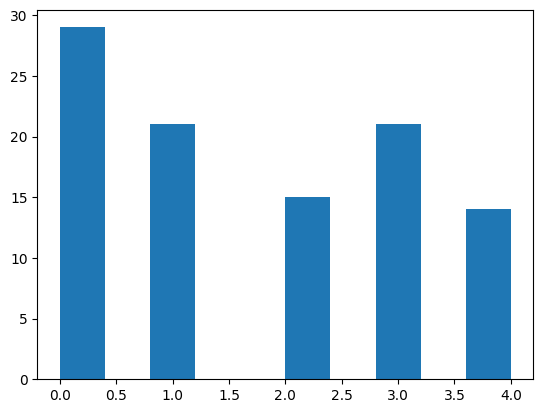

In [405]:
k = 5
gmm = GaussianMixture(n_components=k).fit(url_click)
print("means:", gmm.means_)
clusters = gmm.predict(url_click)
print(clusters.shape)
plt.hist(clusters, label="count of each cluster")
plt.show()

In [406]:
log_likelihood = sum(gmm.score_samples(url_click))
bic = gmm.bic(url_click)
aic = gmm.aic(url_click)

print(f"Log-Likelihood: {log_likelihood}")
print(f"BIC: {bic}")
print(f"AIC: {aic}")

Log-Likelihood: 3980.6308516472573
BIC: -6446.160712104432
AIC: -7303.261703294514
